In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
from scipy.stats import ks_2samp
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
df_records = pd.read_csv('../data/Public_records.csv')
df_perform = pd.read_csv('../data/Loan_performance.csv')
df_data_records = pd.read_excel('../data/Data_dictionary.xlsx')

In [4]:
df_perform[df_perform.late_90_days != 0].iloc[0]

analytics_matchkey    1346779
max_loan_amount          1006
late_30_days                1
late_60_days                1
late_90_days                1
Name: 34, dtype: int64

In [11]:
#assign categories to each late case
# late_30_days, 'late_60_days', 'late_90_days'
# (0,0,0) - 0
# (1,0,0) - 1
# (1,1,0) - 2
# (1,1,1) - 3
df_perform['category'] = pd.Categorical(df_perform['late_30_days'].astype(str) + '_' 
               + df_perform['late_60_days'].astype(str) + '_'
               + df_perform['late_90_days'].astype(str)).codes

df_perform['not_late'] = df_perform.category.apply(lambda x: 1 if x == 0 else 0)

category
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: max_loan_amount, dtype: object

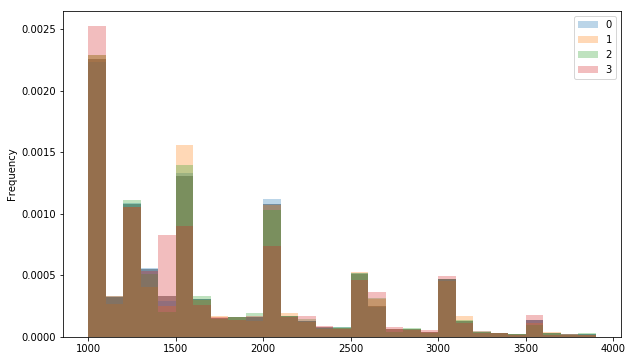

In [12]:
# see if there is difference in terms of max loan capacity between groups of late payers
fig, ax = plt.subplots(figsize=(10,6))
bins = np.arange(1000, 4000, 100)
df_perform.max_loan_amount.hist(bins=bins, ax=ax, color='grey', zorder=0, density=True, alpha=0.8)

df_late_group = df_perform.groupby('category')
df_late_group['max_loan_amount'].plot(kind='hist', alpha=0.3, density=True, legend=True, bins=bins, ax=ax)

# seems like all of these groups completely overlap with the overall distribution of max loan amount

In [13]:
group_dict = {}
for i, group in df_late_group:
    group_dict[i] = group.max_loan_amount.tolist()

In [14]:
key_name_dict = {0:'Good', 1:'30', 2:'60', 3:'90'}

for i, j in list(combinations(group_dict.keys(), 2)):
    print(i, j)
    print(key_name_dict[i], 'vs', key_name_dict[j])
    D, p = ks_2samp(group_dict[i], group_dict[j])
    print('p value: {:.4f}'.format(p))
    print('-------------------')
    
# --> p value using ks 2 sample test comparing maximum loan amount between all groups of late payments indicates that
# there is significant difference between the loan amounts of the different groups

0 1
Good vs 30
p value: 0.0000
-------------------
0 2
Good vs 60
p value: 0.0186
-------------------
0 3
Good vs 90
p value: 0.0000
-------------------
1 2
30 vs 60
p value: 0.0067
-------------------
1 3
30 vs 90
p value: 0.0000
-------------------
2 3
60 vs 90
p value: 0.0000
-------------------


# Let's combine the public data with the performance data!

In [15]:
df_records = df_records.drop(axis=1, columns=['plaintiff_name', 'attorney_name', 'docket_number'])

In [16]:
# Convert the date integers/string to datetime
def convert_to_date(x):
    try:
        return datetime.strptime(str(int(x)), '%Y%m%d')
    except ValueError:
        return np.nan
    
df_records['effective_date_date_verified'] = df_records['effective_date_date_verified'].apply(lambda x: convert_to_date(x))
df_records['filed_date'] = df_records['filed_date'].apply(lambda x: convert_to_date(x))
df_records['paid_date'] = df_records['paid_date'].apply(lambda x: convert_to_date(x))


In [17]:
# nan values for each date columns
df_records.effective_date_date_verified.isna().sum(), df_records.filed_date.isna().sum(), df_records.paid_date.isna().sum()

(285, 0, 88882)

In [18]:
#find the days between each dates ->
df_records['filed_to_paid'] = df_records['paid_date'] - df_records['filed_date']
df_records['paid_to_verified'] = df_records['effective_date_date_verified'] - df_records['paid_date']
df_records['filed_to_verified'] =  df_records['effective_date_date_verified'] - df_records['filed_date']

In [19]:
df = pd.merge(df_records, df_perform, left_on='analytics_matchkey', right_on='analytics_matchkey')

### See if the actual amount of loan is more significantly different between each group of late payers

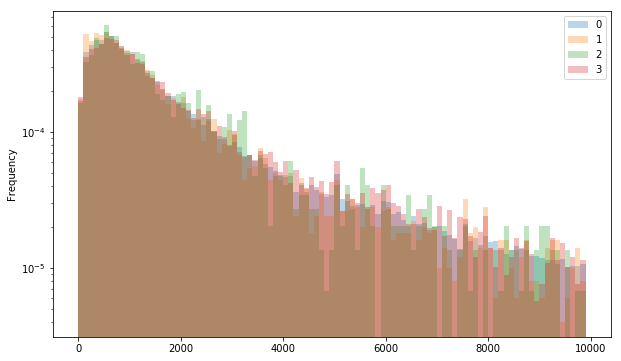

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
bins = np.arange(0, 10000, 100)
# df.amount.hist(ax=ax, color='grey', zorder=0, density=True, alpha=0.1, bins=bins)

df_late_group = df.groupby('category')
df_late_group['amount'].plot(kind='hist', alpha=0.3, density=True, legend=True, ax=ax, bins=bins)

ax.set_yscale('log')
# ax.set_xscale('log')

# Using random forest classifier 
Use the performance data and public records data as variables and actual loan payment category as result

In [8]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier  #GBM algorithm
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score   #Additional scklearn functions
from sklearn.metrics import roc_curve, auc
from sklearn import metrics


In [9]:
df.columns

Index(['analytics_matchkey', 'industry_code_kind_of_business',
       'reporting_subscriber_code', 'public_record_type_code',
       'effective_date_date_verified', 'filed_date', 'paid_date', 'amount',
       'public_record_source_type_code', 'equal_credit_opportunity_act_code',
       'legislative_prohibited_code', 'plaintiff_name', 'attorney_name',
       'docket_number', 'max_loan_amount', 'late_30_days', 'late_60_days',
       'late_90_days', 'category'],
      dtype='object')

In [21]:
#features
features = ['industry_code_kind_of_business', 'reporting_subscriber_code', 'public_record_type_code', 
            'filed_to_paid', 'paid_to_verified', 'filed_to_verified',
            'amount','max_loan_amount',
            'public_record_source_type_code', 'equal_credit_opportunity_act_code', 'legislative_prohibited_code',
            ]
#value we are trying to predict
predict = ['not_late', 'late_30_days', 'late_60_days', 'late_90_days']

#check if any of the columns in features contain nan values
series_nan = df[features].isna().sum()
print(series_nan[series_nan!=0].index)
# df.head()

Index(['filed_to_paid', 'paid_to_verified', 'filed_to_verified', 'amount',
       'public_record_source_type_code'],
      dtype='object')


In [22]:
#fill in missing values with the median (for numerical values) or mode (for categorical values)
for c in ['filed_to_paid', 'paid_to_verified', 'filed_to_verified', 'amount']:
    df[c].fillna(df[c].median(), inplace=True)
for c in ['public_record_source_type_code']:
    df[c].fillna(df[c].mode()[0], inplace=True)

In [23]:
#check if any of the columns in features contain nan values
series_nan = df[features].isna().sum()
print(series_nan[series_nan!=0].index)

Index([], dtype='object')


In [24]:
from sklearn import preprocessing
string_columns = ['industry_code_kind_of_business', 'reporting_subscriber_code', 'public_record_type_code',
                 'public_record_source_type_code', 'equal_credit_opportunity_act_code']

label_dictionary = {}
for c in string_columns:
    le = preprocessing.LabelEncoder()
    le.fit(df[c].unique())
    df[c] = le.transform(df[c])
#     labels = dict(zip(list(le.classes_), le.transform(le.classes_)))
    label_dictionary[c] = le

In [25]:
# Timedelta to int
for c in ['filed_to_paid','paid_to_verified','filed_to_verified']:
    print(c)
    df[c] = df[c].apply(lambda td: int(td / np.timedelta64(1, 'D')))

filed_to_paid
paid_to_verified
filed_to_verified


In [26]:
# shuffle df
df = df.sample(frac=1)
X = df[features]
y = df[predict]

In [ ]:
# parameter test for Random Forest
# took too long to run
# the best params and best score from gsearch will tell us the best features for predicting late payers for RF
# we can also try other categorical classifiers such as SVM and GradientBoosting (with GB, we have to be very careful about overfitting)
param_test_boost = {# boosting specific paramters
          'max_depth':range(2,8,1), 'min_samples_split':[2, 100, 1000, 10000], 
          'min_samples_leaf':[1, 100, 1000], 'max_features':[1,5,11]}
gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=1000, random_state=2),
                            param_grid = param_test_boost, scoring='roc_auc', n_jobs=2, iid=False, cv=5)

gsearch.fit(X, y)

In [ ]:
gsearch.best_params_, gsearch.best_score_

In [27]:
# let's try an example
md = 4
mss = 100
msl= 10
rf = RandomForestClassifier(n_estimators=1000, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, random_state=2)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.4)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [29]:
y_score = rf.predict_proba(X_test)
# p_train = rf.predict_proba(X_train)

In [30]:
y_score = np.array(y_score)

In [32]:
n_classes = y.shape[1]

In [33]:
y_score[0]

array([[0.14442919, 0.85557081],
       [0.1253909 , 0.8746091 ],
       [0.14457308, 0.85542692],
       ...,
       [0.15508549, 0.84491451],
       [0.13000471, 0.86999529],
       [0.17202442, 0.82797558]])

In [34]:
i = 0
roc_curve(y_test.values[:, i], y_score[i][:,0])

(array([0.00000000e+00, 7.65052406e-05, 1.53010481e-04, ...,
        9.99923495e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.99997306, 0.99998653,
        1.        ]),
 array([1.2909435 , 0.2909435 , 0.28689481, ..., 0.11213917, 0.11212684,
        0.11210682]))

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_score[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])


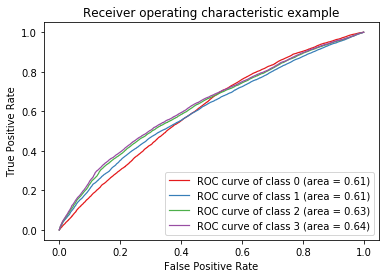

In [37]:
from itertools import cycle
colors = cycle(['#e41a1c', '#377eb8', '#4daf4a','#984ea3'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

### --> needs parameter optimization! 